In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from sklearn.neighbors import NearestNeighbors

In [2]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
print("Energy Consumption Clustering Analysis")
df = pd.read_csv('clustering_features.csv')

print(f"Dataset loaded successfully.")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

Energy Consumption Clustering Analysis
Dataset loaded successfully.
Shape: (118, 17)
Columns: ['ICP_IDENTIFIER', 'num_rooms', 'avg_power_kW', 'peak_kW', 'peak_to_avg_ratio', 'load_factor', 'coefficient_of_variation', 'temperature_correlation', 'heating_sensitivity_kWh', 'night_usage_ratio', 'morning_usage_ratio', 'daytime_usage_ratio', 'evening_usage_ratio', 'daily_usage_consistency', 'weekday_weekend_ratio', 'usage_concentration', 'avg_power_per_room']

First few rows:
    ICP_IDENTIFIER  num_rooms  avg_power_kW  peak_kW  peak_to_avg_ratio  \
0  0000002795DE203         11          2.42    10.46               4.32   
1  0000002805DE2EB          9          2.45    20.30               8.29   
2  0000002806DEE2B          5          2.45    11.54               4.71   
3  0000002807DE26E          4          1.96    10.38               5.29   
4  0000002810DE509          4          1.13     9.86               8.70   

   load_factor  coefficient_of_variation  temperature_correlation  \
0    

Feature Correlation Analysis
Analysing 16 features:
 1. num_rooms
 2. avg_power_kW
 3. peak_kW
 4. peak_to_avg_ratio
 5. load_factor
 6. coefficient_of_variation
 7. temperature_correlation
 8. heating_sensitivity_kWh
 9. night_usage_ratio
10. morning_usage_ratio
11. daytime_usage_ratio
12. evening_usage_ratio
13. daily_usage_consistency
14. weekday_weekend_ratio
15. usage_concentration
16. avg_power_per_room


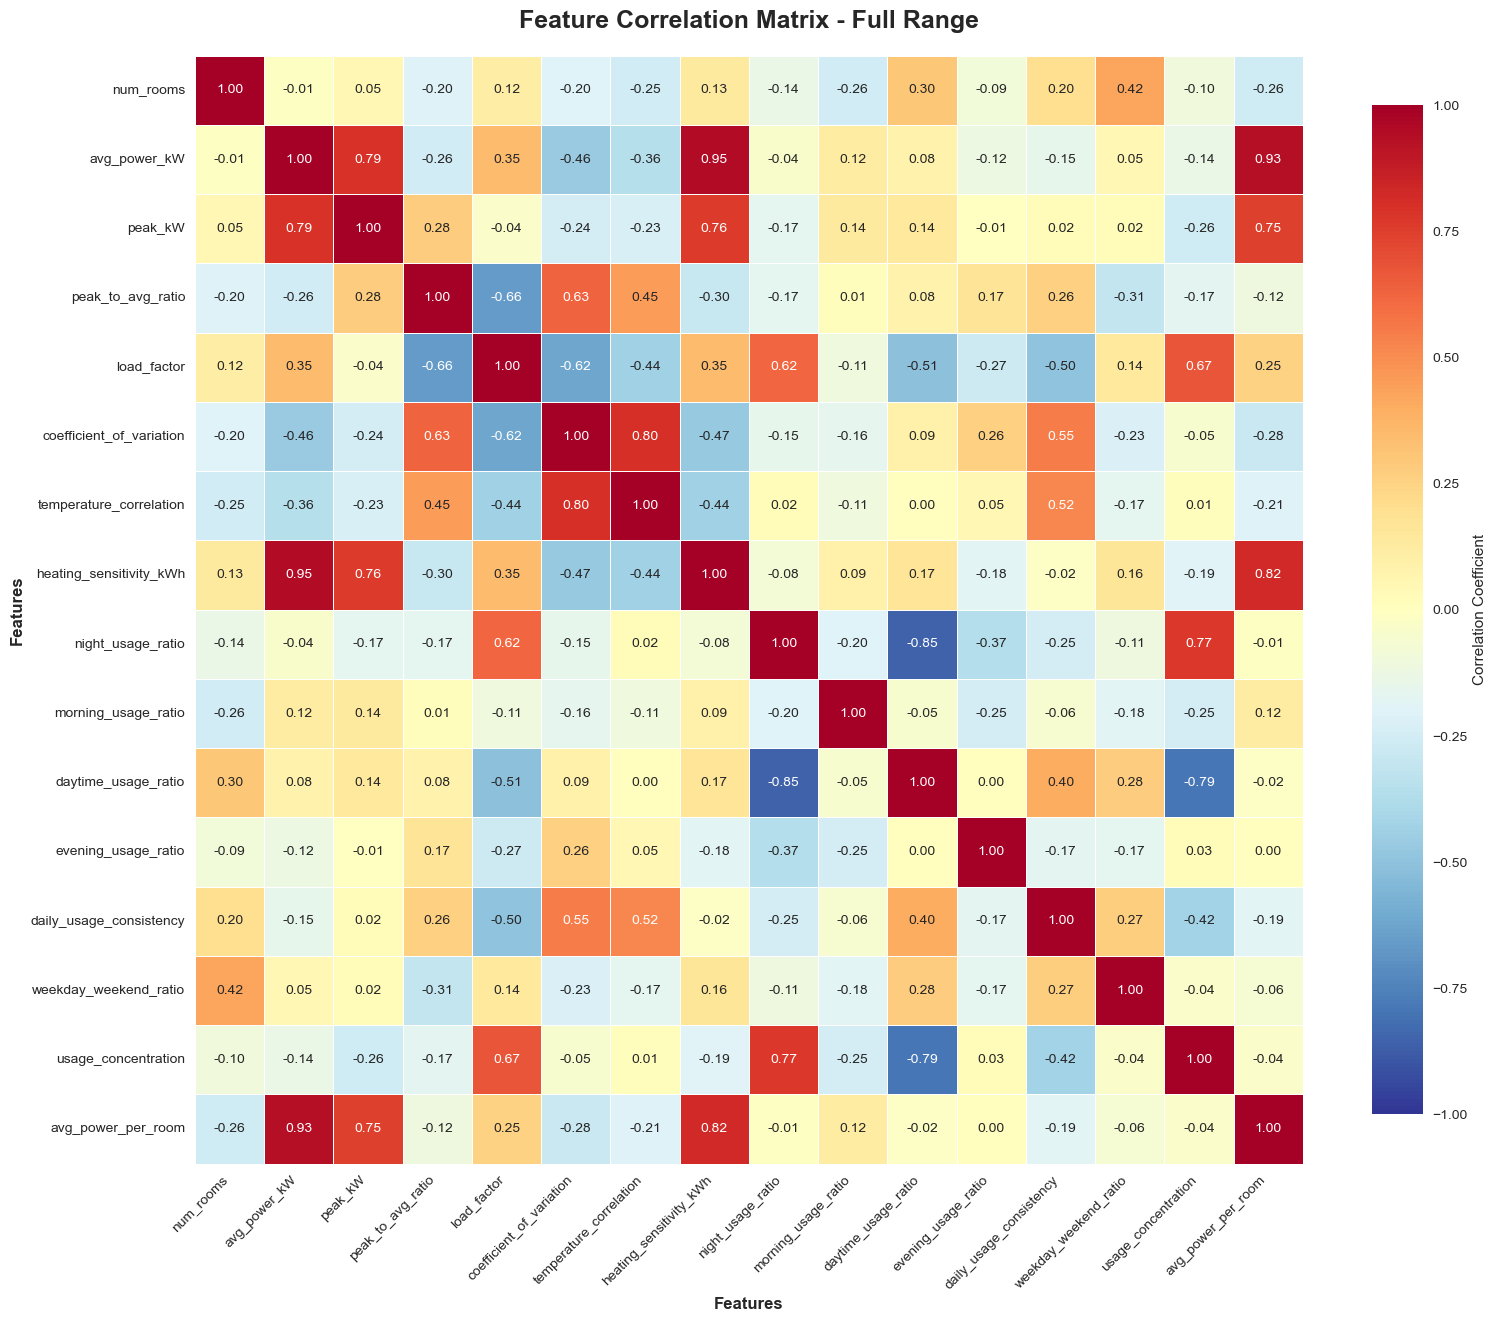

In [4]:
print("Feature Correlation Analysis")
# Separate features 
features = df.drop('ICP_IDENTIFIER', axis=1)
feature_names = features.columns.tolist()

print(f"Analysing {len(feature_names)} features:")
for i, feature in enumerate(feature_names, 1):
    print(f"{i:2d}. {feature}")

# Calculate correlation matrix
correlation_matrix = features.corr()


# Create correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            vmin=-1, 
            vmax=1,
            fmt='.2f',
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
            annot_kws={'size': 10})
plt.title('Feature Correlation Matrix - Full Range', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [5]:
# Highly correlated pairs (>0.8 or <-0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                corr_val
            ))

print(f"\nHighly correlated feature pairs (|correlation| > 0.8):")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("  No highly correlated pairs found.")


Highly correlated feature pairs (|correlation| > 0.8):
  avg_power_kW <-> heating_sensitivity_kWh: 0.949
  avg_power_kW <-> avg_power_per_room: 0.935
  coefficient_of_variation <-> temperature_correlation: 0.804
  heating_sensitivity_kWh <-> avg_power_per_room: 0.823
  night_usage_ratio <-> daytime_usage_ratio: -0.855


In [6]:
print("Feature Reduction and Scaling")
features_to_remove = [
    'heating_sensitivity_kWh',  # Too similar to avg_power_kW
    'avg_power_per_room',       # Too similar to avg_power_kW
    'temperature_correlation',   # Too similar to coefficient_of_variation
    'daytime_usage_ratio'       # Inverse of night_usage_ratio
]

print("Features to remove due to high correlation:")
for i, feature in enumerate(features_to_remove, 1):
    print(f"  {i}. {feature}")

# Create reduced feature set
features_reduced = features.drop(columns=features_to_remove)
reduced_feature_names = features_reduced.columns.tolist()

print(f"\nReduced feature set ({len(reduced_feature_names)} features):")
for i, feature in enumerate(reduced_feature_names, 1):
    print(f"  {i:2d}. {feature}")

scaler = RobustScaler()
features_scaled = scaler.fit_transform(features_reduced)
features_scaled_df = pd.DataFrame(features_scaled, 
                                 columns=reduced_feature_names,
                                 index=df.index)

print(f"\nFeature scaling completed using RobustScaler.")
print(f"  Original features: {len(feature_names)}")
print(f"  Reduced features: {len(reduced_feature_names)}")
print(f"  Features removed: {len(features_to_remove)}")
print(f"  Scaled data shape: {features_scaled_df.shape}")

# Show scaling effect
print(f"\nRobustScaler verification:")
print(f"  Median of scaled features: {features_scaled_df.median().mean():.6f}")
print(f"  IQR of scaled features: {(features_scaled_df.quantile(0.75) - features_scaled_df.quantile(0.25)).mean():.6f}")  

Feature Reduction and Scaling
Features to remove due to high correlation:
  1. heating_sensitivity_kWh
  2. avg_power_per_room
  3. temperature_correlation
  4. daytime_usage_ratio

Reduced feature set (12 features):
   1. num_rooms
   2. avg_power_kW
   3. peak_kW
   4. peak_to_avg_ratio
   5. load_factor
   6. coefficient_of_variation
   7. night_usage_ratio
   8. morning_usage_ratio
   9. evening_usage_ratio
  10. daily_usage_consistency
  11. weekday_weekend_ratio
  12. usage_concentration

Feature scaling completed using RobustScaler.
  Original features: 16
  Reduced features: 12
  Features removed: 4
  Scaled data shape: (118, 12)

RobustScaler verification:
  Median of scaled features: 0.000000
  IQR of scaled features: 0.916667


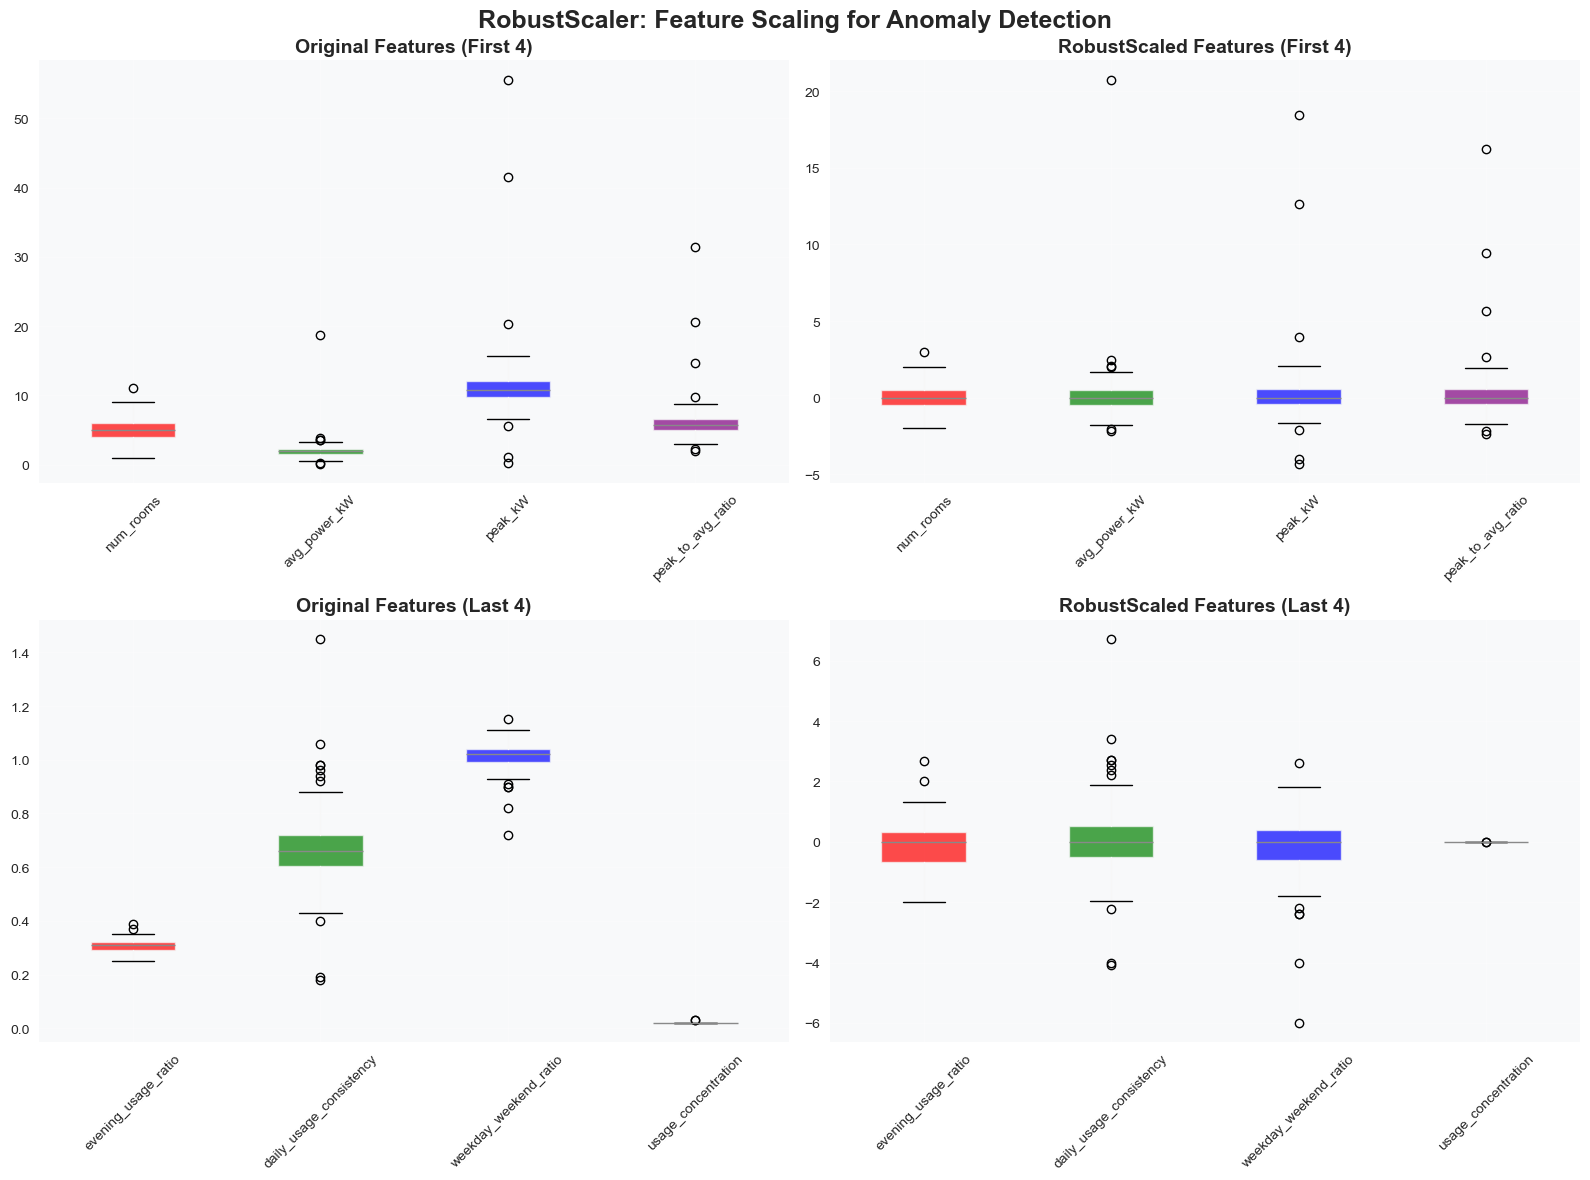

In [7]:
# Visualization of feature distributions before/after scaling with colours
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RobustScaler: Feature Scaling for Anomaly Detection', fontsize=18, fontweight='bold')

# Colour palette for better visuals
colors = ['red', 'green', 'blue', 'purple']

# Before scaling - first 4 features
bp1 = features_reduced.iloc[:, :4].boxplot(ax=axes[0, 0], return_type='dict', patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 0].set_title('Original Features (First 4)', fontweight='bold', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# After scaling - first 4 features  
bp2 = features_scaled_df.iloc[:, :4].boxplot(ax=axes[0, 1], return_type='dict', patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0, 1].set_title('RobustScaled Features (First 4)', fontweight='bold', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Before scaling - last 4 features
bp3 = features_reduced.iloc[:, -4:].boxplot(ax=axes[1, 0], return_type='dict', patch_artist=True)
for patch, color in zip(bp3['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_title('Original Features (Last 4)', fontweight='bold', fontsize=14)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# After scaling - last 4 features
bp4 = features_scaled_df.iloc[:, -4:].boxplot(ax=axes[1, 1], return_type='dict', patch_artist=True)
for patch, color in zip(bp4['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_title('RobustScaled Features (Last 4)', fontweight='bold', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.set_facecolor('#F8F9FA')
    
plt.tight_layout()
plt.show()

In [8]:
print("Determining Optimal Number of Clusters")
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...")
print("K\tInertia\t\tSilhouette Score")

Determining Optimal Number of Clusters
Testing different numbers of clusters...
K	Inertia		Silhouette Score


2	1812.98		0.838
3	1365.55		0.718
4	1088.41		0.681
5	881.78		0.665
6	704.26		0.192
7	607.08		0.201
8	531.93		0.196
9	482.32		0.164
10	436.00		0.181


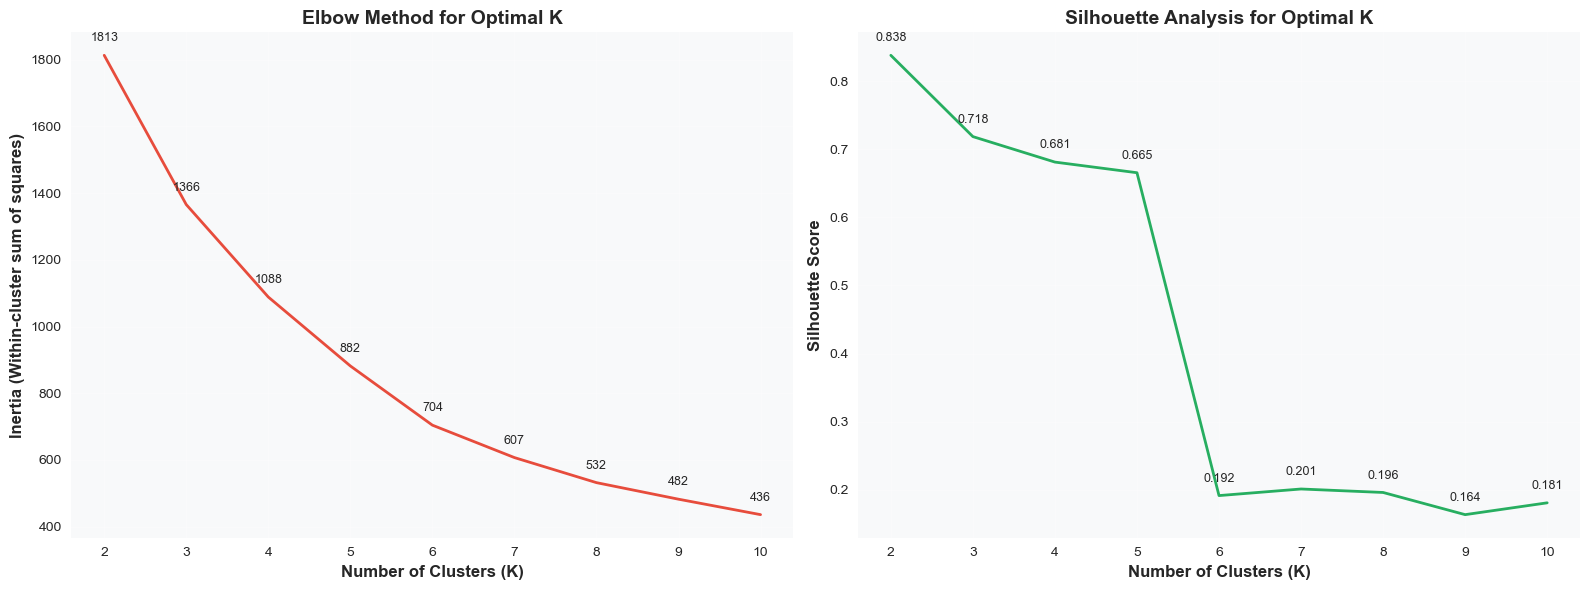

In [9]:
# Calculate metrics for each K
for k in k_range:
    # K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    sil_score = silhouette_score(features_scaled, cluster_labels)
    
    inertias.append(inertia)
    silhouette_scores.append(sil_score)
    
    print(f"{k}\t{inertia:.2f}\t\t{sil_score:.3f}")

# Create visualisation for optimal K selection
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Method Plot
axes[0].plot(k_range, inertias, linewidth=2, markersize=8, color='#E74C3C')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_facecolor('#F8F9FA')

# Add annotations for better interpretation
for i, (k, inertia) in enumerate(zip(k_range, inertias)):
    axes[0].annotate(f'{inertia:.0f}', (k, inertia), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

# Silhouette Score Plot
axes[1].plot(k_range, silhouette_scores, linewidth=2, markersize=8, color='#27AE60')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Analysis for Optimal K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_facecolor('#F8F9FA')

# Add annotations
for i, (k, score) in enumerate(zip(k_range, silhouette_scores)):
    axes[1].annotate(f'{score:.3f}', (k, score), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [10]:
# Find optimal K
# Elbow method: looking for the "elbow" point
best_k_elbow = k_range[inertias.index(min(inertias))] 

# Silhouette method: highest silhouette score
best_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nOptimal K Analysis:")
print(f"Highest Silhouette Score: K = {best_k_silhouette} (Score: {max(silhouette_scores):.3f})")


Optimal K Analysis:
Highest Silhouette Score: K = 2 (Score: 0.838)


In [11]:
# Detailed silhouette analysis for top candidates
top_k_candidates = [3, 4, 5]  # Common good choices for energy clustering

print(f"\nDetailed analysis for K = {top_k_candidates}:")
for k in top_k_candidates:
    idx = k - 2  # Adjust for index (k_range starts at 2)
    print(f"  K={k}: Silhouette={silhouette_scores[idx]:.3f}, Inertia={inertias[idx]:.2f}")


Detailed analysis for K = [3, 4, 5]:
  K=3: Silhouette=0.718, Inertia=1365.55
  K=4: Silhouette=0.681, Inertia=1088.41
  K=5: Silhouette=0.665, Inertia=881.78


Multi-K Clustering Analysis
Performing clustering analysis for K = 2, 3, 4...

Clustering Results Summary:
K	Silhouette	Cluster Sizes
2	0.838		[117   1]
3	0.718		[  3   1 114]
4	0.681		[  3   1 112   2]


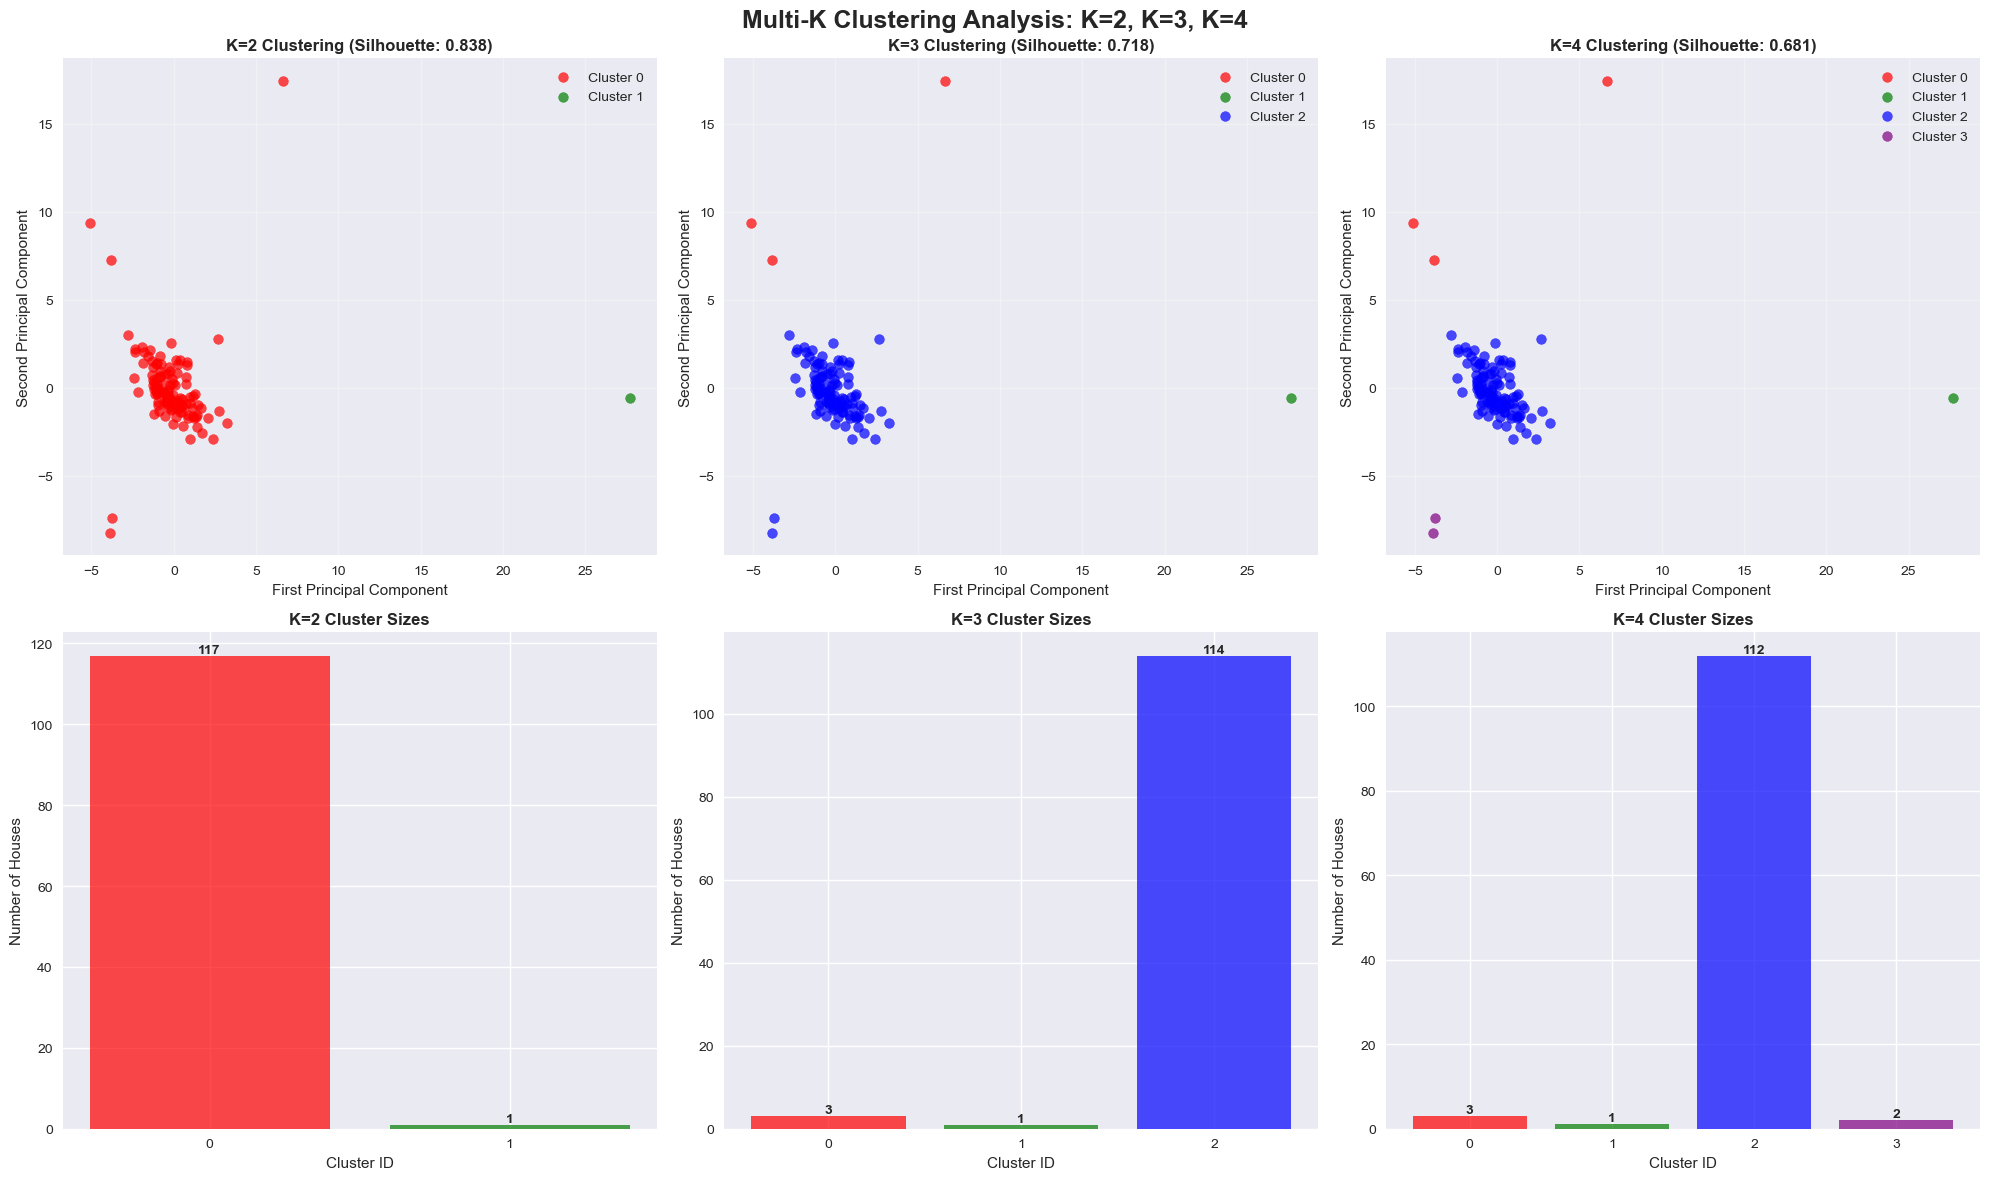

In [12]:
print("Multi-K Clustering Analysis")
# Perform clustering for K=2, 3, 4 and analyse each
k_values = [2, 3, 4]
clustering_results = {}

print("Performing clustering analysis for K = 2, 3, 4...")
print("\nClustering Results Summary:")
print("K\tSilhouette\tCluster Sizes")

# Run clustering for each K value
for k in k_values:
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled)
    
    # Calculate metrics
    sil_score = silhouette_score(features_scaled, cluster_labels)
    cluster_counts = np.bincount(cluster_labels)
    
    # Store results
    clustering_results[k] = {
        'model': kmeans,
        'labels': cluster_labels,
        'silhouette': sil_score,
        'cluster_counts': cluster_counts,
        'cluster_centers': kmeans.cluster_centers_
    }
    
    print(f"{k}\t{sil_score:.3f}\t\t{cluster_counts}")

# Create comprehensive visualisation of all clustering results
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Multi-K Clustering Analysis: K=2, K=3, K=4', fontsize=18, fontweight='bold')

# Use PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_scaled)

# Color palettes for different K values
colors_k2 = ['red', 'green']
colors_k3 = ['red', 'green', 'blue'] 
colors_k4 = ['red', 'green', 'blue', 'purple']

# Plot clustering results for each K
for idx, k in enumerate(k_values):
    labels = clustering_results[k]['labels']
    
    # Top row: PCA scatter plots
    ax_scatter = axes[0, idx]
    if k == 2:
        colors = colors_k2
    elif k == 3:
        colors = colors_k3
    else:
        colors = colors_k4
    
    for cluster_id in range(k):
        cluster_mask = labels == cluster_id
        ax_scatter.scatter(features_pca[cluster_mask, 0], 
                          features_pca[cluster_mask, 1],
                          c=colors[cluster_id], 
                          label=f'Cluster {cluster_id}',
                          alpha=0.7, s=50)
    
    ax_scatter.set_title(f'K={k} Clustering (Silhouette: {clustering_results[k]["silhouette"]:.3f})', 
                        fontweight='bold', fontsize=12)
    ax_scatter.set_xlabel('First Principal Component')
    ax_scatter.set_ylabel('Second Principal Component')
    ax_scatter.legend()
    ax_scatter.grid(True, alpha=0.3)
    
    # Bottom row: Cluster size distribution
    ax_bar = axes[1, idx]
    cluster_counts = clustering_results[k]['cluster_counts']
    bars = ax_bar.bar(range(k), cluster_counts, color=colors[:k], alpha=0.7)
    ax_bar.set_title(f'K={k} Cluster Sizes', fontweight='bold', fontsize=12)
    ax_bar.set_xlabel('Cluster ID')
    ax_bar.set_ylabel('Number of Houses')
    ax_bar.set_xticks(range(k))
    
    # Add count annotations on bars
    for bar, count in zip(bars, cluster_counts):
        ax_bar.annotate(f'{count}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                       ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# Analyse cluster characteristics for each K
print("DETAILED CLUSTER CHARACTERISTICS ANALYSIS")
for k in k_values:
    print(f"\n K={k} ANALYSIS:")
    
    labels = clustering_results[k]['labels']
    
    # Add cluster labels to dataframe for analysis
    df_with_clusters = features_reduced.copy()
    df_with_clusters['cluster'] = labels
    
    # Calculate cluster statistics
    cluster_stats = df_with_clusters.groupby('cluster').agg({
        'avg_power_kW': ['mean', 'std', 'min', 'max'],
        'peak_kW': ['mean', 'std'],
        'num_rooms': ['mean', 'std'],
        'load_factor': ['mean', 'std'],
        'night_usage_ratio': ['mean', 'std']
    }).round(3)
    
    print("Key Metrics by Cluster:")
    for cluster_id in range(k):
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        size = len(cluster_data)
        avg_power = cluster_data['avg_power_kW'].mean()
        peak_power = cluster_data['peak_kW'].mean()
        avg_rooms = cluster_data['num_rooms'].mean()
        
        print(f"  Cluster {cluster_id} (n={size}):")
        print(f"    - Avg Power: {avg_power:.2f} kW")
        print(f"    - Peak Power: {peak_power:.2f} kW") 
        print(f"    - Avg Rooms: {avg_rooms:.1f}")
    
    # Display detailed statistics table
    print(f"\nDetailed Statistics for K={k}:")
    print(cluster_stats)

DETAILED CLUSTER CHARACTERISTICS ANALYSIS

 K=2 ANALYSIS:
Key Metrics by Cluster:
  Cluster 0 (n=117):
    - Avg Power: 1.92 kW
    - Peak Power: 11.10 kW
    - Avg Rooms: 4.7
  Cluster 1 (n=1):
    - Avg Power: 18.74 kW
    - Peak Power: 55.60 kW
    - Avg Rooms: 1.0

Detailed Statistics for K=2:
        avg_power_kW                      peak_kW        num_rooms         \
                mean    std    min    max    mean    std      mean    std   
cluster                                                                     
0              1.919  0.648   0.14   3.90  11.099  3.714     4.658  1.504   
1             18.740    NaN  18.74  18.74  55.600    NaN     1.000    NaN   

        load_factor        night_usage_ratio        
               mean    std              mean   std  
cluster                                             
0              0.18  0.058             0.251  0.05  
1              0.34    NaN             0.250   NaN  

 K=3 ANALYSIS:
Key Metrics by Cluster:
  Cluster 

In [14]:
print("MULTI-K CLUSTERING SUMMARY")

# Summary comparison of all K values
print("K\tSilhouette\tCluster Sizes")

for k in k_values:
    sil = clustering_results[k]['silhouette']
    counts = clustering_results[k]['cluster_counts']
    counts_str = str(list(counts))
    print(f"{k}\t{sil:.3f}\t\t{counts_str}")

# PCA explained variance
print(f"\nPCA Information:")
print(f" Explained variance ratio: {pca.explained_variance_ratio_}")
print(f" Total variance explained: {pca.explained_variance_ratio_.sum():.3f}")


MULTI-K CLUSTERING SUMMARY
K	Silhouette	Cluster Sizes
2	0.838		[117, 1]
3	0.718		[3, 1, 114]
4	0.681		[3, 1, 112, 2]

PCA Information:
 Explained variance ratio: [0.39412877 0.28837601]
 Total variance explained: 0.683


In [15]:
print("Performing Hierarchical Clustering analysis...")

# Test different linkage methods
linkage_methods = ['ward', 'complete', 'average']
hierarchical_results = {}

print("\nHierarchical Clustering with different linkage methods:")
print("Method\t\tSilhouette Score (K=3)")

# Hierarchical clustering with different linkage methods
for method in linkage_methods:
    # Clustering with K=3 for comparison
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage=method)
    hier_labels = hierarchical.fit_predict(features_scaled)
    
    # Calculate silhouette score
    hier_silhouette = silhouette_score(features_scaled, hier_labels)
    
    # Store results
    hierarchical_results[method] = {
        'model': hierarchical,
        'labels': hier_labels,
        'silhouette': hier_silhouette,
        'cluster_counts': np.bincount(hier_labels)
    }
    
    print(f"{method}\t\t{hier_silhouette:.3f}")

# Dendrogram for the best linkage method
best_linkage = max(hierarchical_results.keys(), key=lambda x: hierarchical_results[x]['silhouette'])
print(f"\nBest linkage method: {best_linkage} (Silhouette: {hierarchical_results[best_linkage]['silhouette']:.3f})")

Performing Hierarchical Clustering analysis...

Hierarchical Clustering with different linkage methods:
Method		Silhouette Score (K=3)
ward		0.718
complete		0.718
average		0.787

Best linkage method: average (Silhouette: 0.787)



Generating dendrogram...


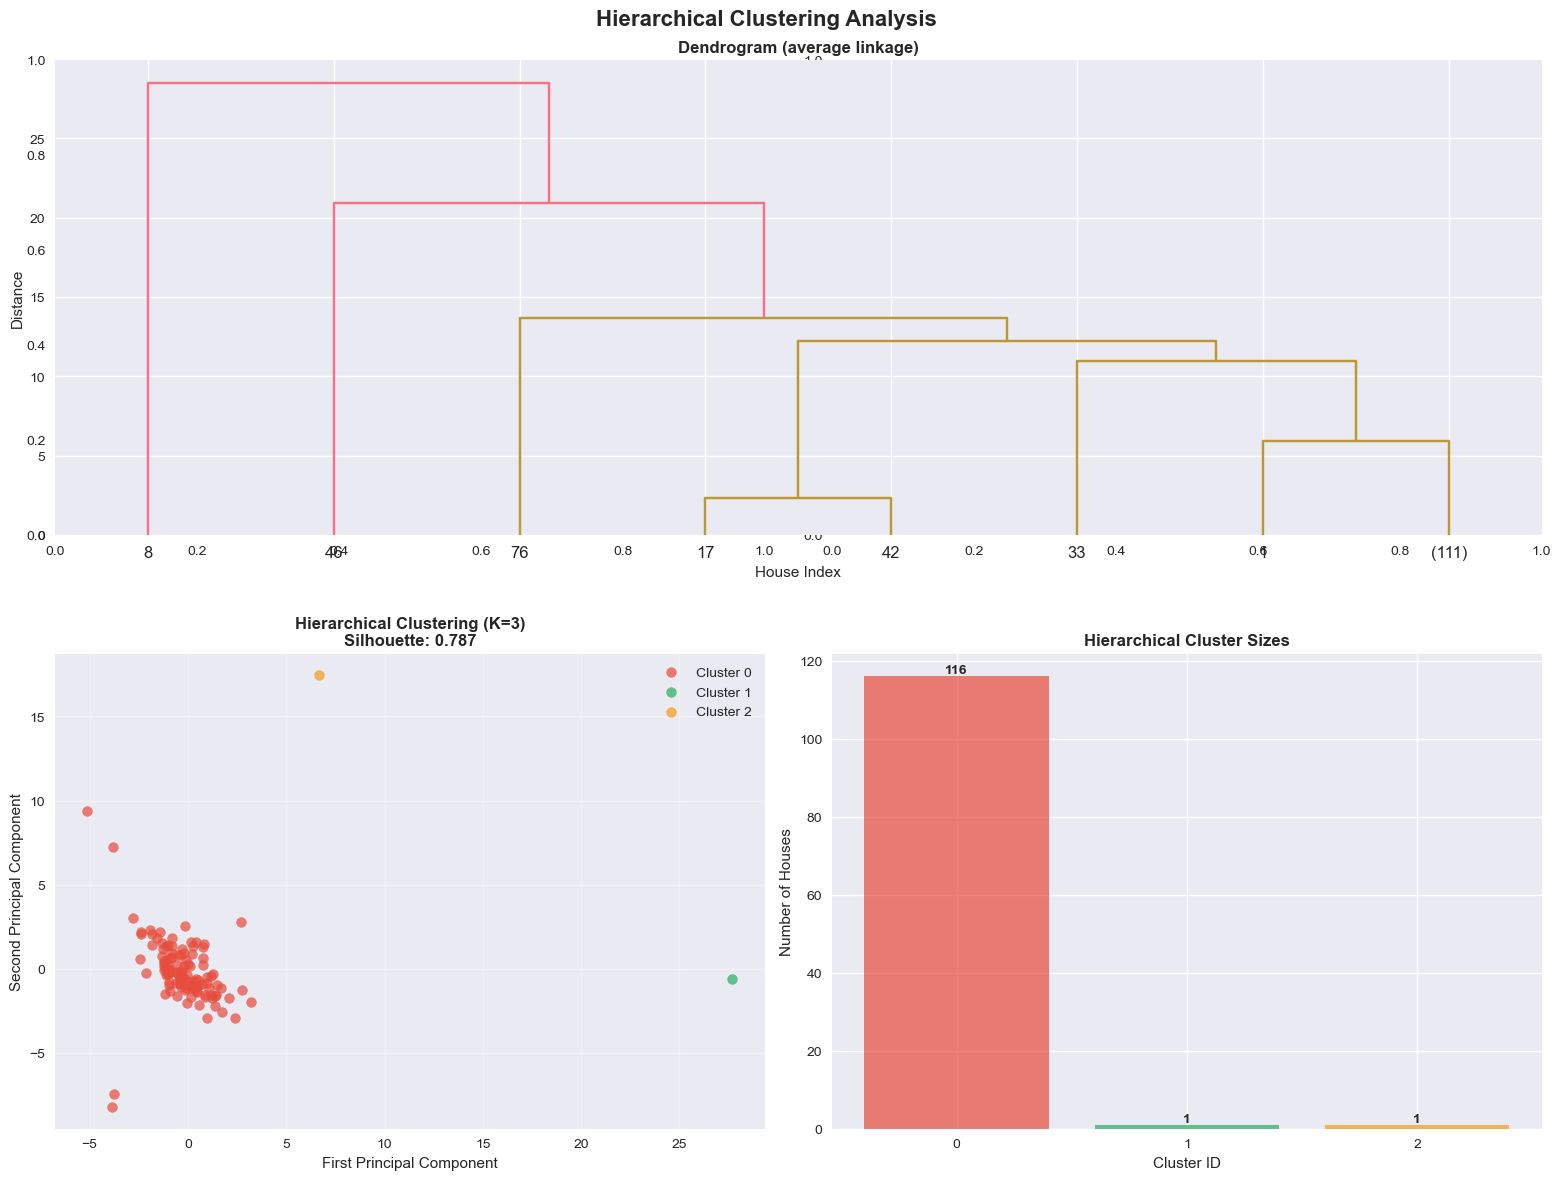

In [16]:
# Create linkage matrix for dendrogram
print("\nGenerating dendrogram...")
linkage_matrix = linkage(features_scaled, method=best_linkage)
# Create visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hierarchical Clustering Analysis', fontsize=16, fontweight='bold')

# Dendrogram
ax_dendro = axes[0, :]
ax_dendro = plt.subplot2grid((2, 2), (0, 0), colspan=2)
dendrogram(linkage_matrix, ax=ax_dendro, truncate_mode='level', p=5)
ax_dendro.set_title(f'Dendrogram ({best_linkage} linkage)', fontweight='bold')
ax_dendro.set_xlabel('House Index')
ax_dendro.set_ylabel('Distance')

# PCA scatter plot for hierarchical clustering (K=3)
ax_scatter = axes[1, 0]
hier_labels_best = hierarchical_results[best_linkage]['labels']
colors_hier = ['#E74C3C', '#27AE60', '#F39C12']

for cluster_id in range(3):
    cluster_mask = hier_labels_best == cluster_id
    ax_scatter.scatter(features_pca[cluster_mask, 0], 
                      features_pca[cluster_mask, 1],
                      c=colors_hier[cluster_id], 
                      label=f'Cluster {cluster_id}',
                      alpha=0.7, s=50)

ax_scatter.set_title(f'Hierarchical Clustering (K=3)\nSilhouette: {hierarchical_results[best_linkage]["silhouette"]:.3f}', 
                    fontweight='bold')
ax_scatter.set_xlabel('First Principal Component')
ax_scatter.set_ylabel('Second Principal Component')
ax_scatter.legend()
ax_scatter.grid(True, alpha=0.3)

# Cluster sizes comparison
ax_bar = axes[1, 1]
cluster_counts_hier = hierarchical_results[best_linkage]['cluster_counts']
bars = ax_bar.bar(range(3), cluster_counts_hier, color=colors_hier, alpha=0.7)
ax_bar.set_title('Hierarchical Cluster Sizes', fontweight='bold')
ax_bar.set_xlabel('Cluster ID')
ax_bar.set_ylabel('Number of Houses')
ax_bar.set_xticks(range(3))

# Add count annotations
for bar, count in zip(bars, cluster_counts_hier):
    ax_bar.annotate(f'{count}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                   ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
# Analyse hierarchical clustering characteristics
print("HIERARCHICAL CLUSTERING CHARACTERISTICS")

# Add hierarchical cluster labels to dataframe
df_hier = features_reduced.copy()
df_hier['hier_cluster'] = hier_labels_best

print(f"\nHierarchical Clustering Results ({best_linkage} linkage):")
print("Cluster\tSize\tAvg Power\tPeak Power\tAvg Rooms")
print("-" * 55)

for cluster_id in range(3):
    cluster_data = df_hier[df_hier['hier_cluster'] == cluster_id]
    size = len(cluster_data)
    avg_power = cluster_data['avg_power_kW'].mean()
    peak_power = cluster_data['peak_kW'].mean()
    avg_rooms = cluster_data['num_rooms'].mean()
    
    print(f"{cluster_id}\t{size}\t{avg_power:.2f} kW\t{peak_power:.2f} kW\t{avg_rooms:.1f}")

# Detailed statistics
hier_stats = df_hier.groupby('hier_cluster').agg({
    'avg_power_kW': ['mean', 'std', 'min', 'max'],
    'peak_kW': ['mean', 'std'],
    'num_rooms': ['mean', 'std'],
    'load_factor': ['mean', 'std'],
    'night_usage_ratio': ['mean', 'std']
}).round(3)

print(f"\nDetailed Hierarchical Statistics:")
print(hier_stats)


HIERARCHICAL CLUSTERING CHARACTERISTICS

Hierarchical Clustering Results (average linkage):
Cluster	Size	Avg Power	Peak Power	Avg Rooms
-------------------------------------------------------
0	116	1.92 kW	10.84 kW	4.7
1	1	18.74 kW	55.60 kW	1.0
2	1	1.32 kW	41.48 kW	5.0

Detailed Hierarchical Statistics:
             avg_power_kW                      peak_kW        num_rooms        \
                     mean    std    min    max    mean    std      mean   std   
hier_cluster                                                                    
0                   1.924  0.648   0.14   3.90  10.838  2.413     4.655  1.51   
1                  18.740    NaN  18.74  18.74  55.600    NaN     1.000   NaN   
2                   1.320    NaN   1.32   1.32  41.480    NaN     5.000   NaN   

             load_factor        night_usage_ratio        
                    mean    std              mean   std  
hier_cluster                                             
0                  0.181  0.056   

In [18]:
print("Performing DBSCAN Clustering analysis...")

# Check data integrity 
print("\nData integrity check:")
print(f"Rooms - Min: {features_reduced['num_rooms'].min()}, Max: {features_reduced['num_rooms'].max()}")
print(f"Unique room values: {sorted(features_reduced['num_rooms'].unique())}")

print("\nUsing PCA features for DBSCAN (avoiding curse of dimensionality)...")

# Find optimal eps using k-distance graph on PCA features
print("\nOptimizing eps parameter using k-distance graph...")
k = 4  # min_samples + 1
nbrs = NearestNeighbors(n_neighbors=k).fit(features_pca)
distances, indices = nbrs.kneighbors(features_pca)
distances_sorted = np.sort(distances[:, k-1], axis=0)

# Test realistic eps values for PCA space
eps_values = [0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2]
min_samples_values = [3, 4, 5]

dbscan_results = {}

print("\nTesting DBSCAN parameters on PCA features:")
print("eps\tmin_samples\tClusters\tNoise Points\tNoise %\tSilhouette")
print("-" * 70)

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(features_pca)
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        noise_pct = (n_noise / len(dbscan_labels)) * 100
        
        # Calculate silhouette score only if we have more than 1 cluster
        if n_clusters > 1:
            # Remove noise points for silhouette calculation
            mask = dbscan_labels != -1
            if np.sum(mask) > 1:
                sil_score = silhouette_score(features_pca[mask], dbscan_labels[mask])
            else:
                sil_score = -1
        else:
            sil_score = -1
        
        print(f"{eps}\t{min_samples}\t\t{n_clusters}\t\t{n_noise}\t\t{noise_pct:.1f}%\t{sil_score:.3f}")
        
        # Store results
        dbscan_results[(eps, min_samples)] = {
            'model': dbscan,
            'labels': dbscan_labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': sil_score
        }
        
        # Prefer results with reasonable noise percentage (<50%) and good silhouette
        if sil_score > best_score and noise_pct < 50:
            best_score = sil_score
            best_params = (eps, min_samples)

# Use best parameters if found, otherwise use reasonable defaults
if best_params is not None:
    print(f"\nBest DBSCAN parameters: eps={best_params[0]}, min_samples={best_params[1]}")
    print(f"Best silhouette score: {best_score:.3f}")
    final_result = dbscan_results[best_params]
else:
    # Fallback to reasonable parameters
    print(f"\nNo optimal parameters found with <50% noise. Using fallback: eps=0.5, min_samples=3")
    fallback_eps, fallback_min_samples = 0.5, 3
    dbscan_fallback = DBSCAN(eps=fallback_eps, min_samples=fallback_min_samples)
    fallback_labels = dbscan_fallback.fit_predict(features_pca)
    
    n_clusters_fb = len(set(fallback_labels)) - (1 if -1 in fallback_labels else 0)
    n_noise_fb = list(fallback_labels).count(-1)
    noise_pct_fb = (n_noise_fb / len(fallback_labels)) * 100
    
    if n_clusters_fb > 1:
        mask_fb = fallback_labels != -1
        sil_fb = silhouette_score(features_pca[mask_fb], fallback_labels[mask_fb])
    else:
        sil_fb = -1
    
    final_result = {
        'model': dbscan_fallback,
        'labels': fallback_labels,
        'n_clusters': n_clusters_fb,
        'n_noise': n_noise_fb,
        'noise_pct': noise_pct_fb,
        'silhouette': sil_fb
    }
    best_params = (fallback_eps, fallback_min_samples)

dbscan_labels = final_result['labels']


Performing DBSCAN Clustering analysis...

Data integrity check:
Rooms - Min: 1, Max: 11
Unique room values: [1, 2, 3, 4, 5, 6, 7, 9, 11]

Using PCA features for DBSCAN (avoiding curse of dimensionality)...

Optimizing eps parameter using k-distance graph...

Testing DBSCAN parameters on PCA features:
eps	min_samples	Clusters	Noise Points	Noise %	Silhouette
----------------------------------------------------------------------
0.3	3		7		45		38.1%	0.170
0.3	4		4		57		48.3%	0.164
0.3	5		3		72		61.0%	0.260
0.4	3		3		33		28.0%	0.146
0.4	4		2		40		33.9%	0.338
0.4	5		3		47		39.8%	0.267
0.5	3		2		22		18.6%	0.243
0.5	4		2		24		20.3%	0.265
0.5	5		2		31		26.3%	0.299
0.6	3		1		16		13.6%	-1.000
0.6	4		1		17		14.4%	-1.000
0.6	5		1		18		15.3%	-1.000
0.8	3		1		14		11.9%	-1.000
0.8	4		1		15		12.7%	-1.000
0.8	5		1		15		12.7%	-1.000
1.0	3		1		7		5.9%	-1.000
1.0	4		1		8		6.8%	-1.000
1.0	5		1		9		7.6%	-1.000
1.2	3		1		7		5.9%	-1.000
1.2	4		1		7		5.9%	-1.000
1.2	5		1		7		5.9%	-1.000

Best DBSCAN parameters:

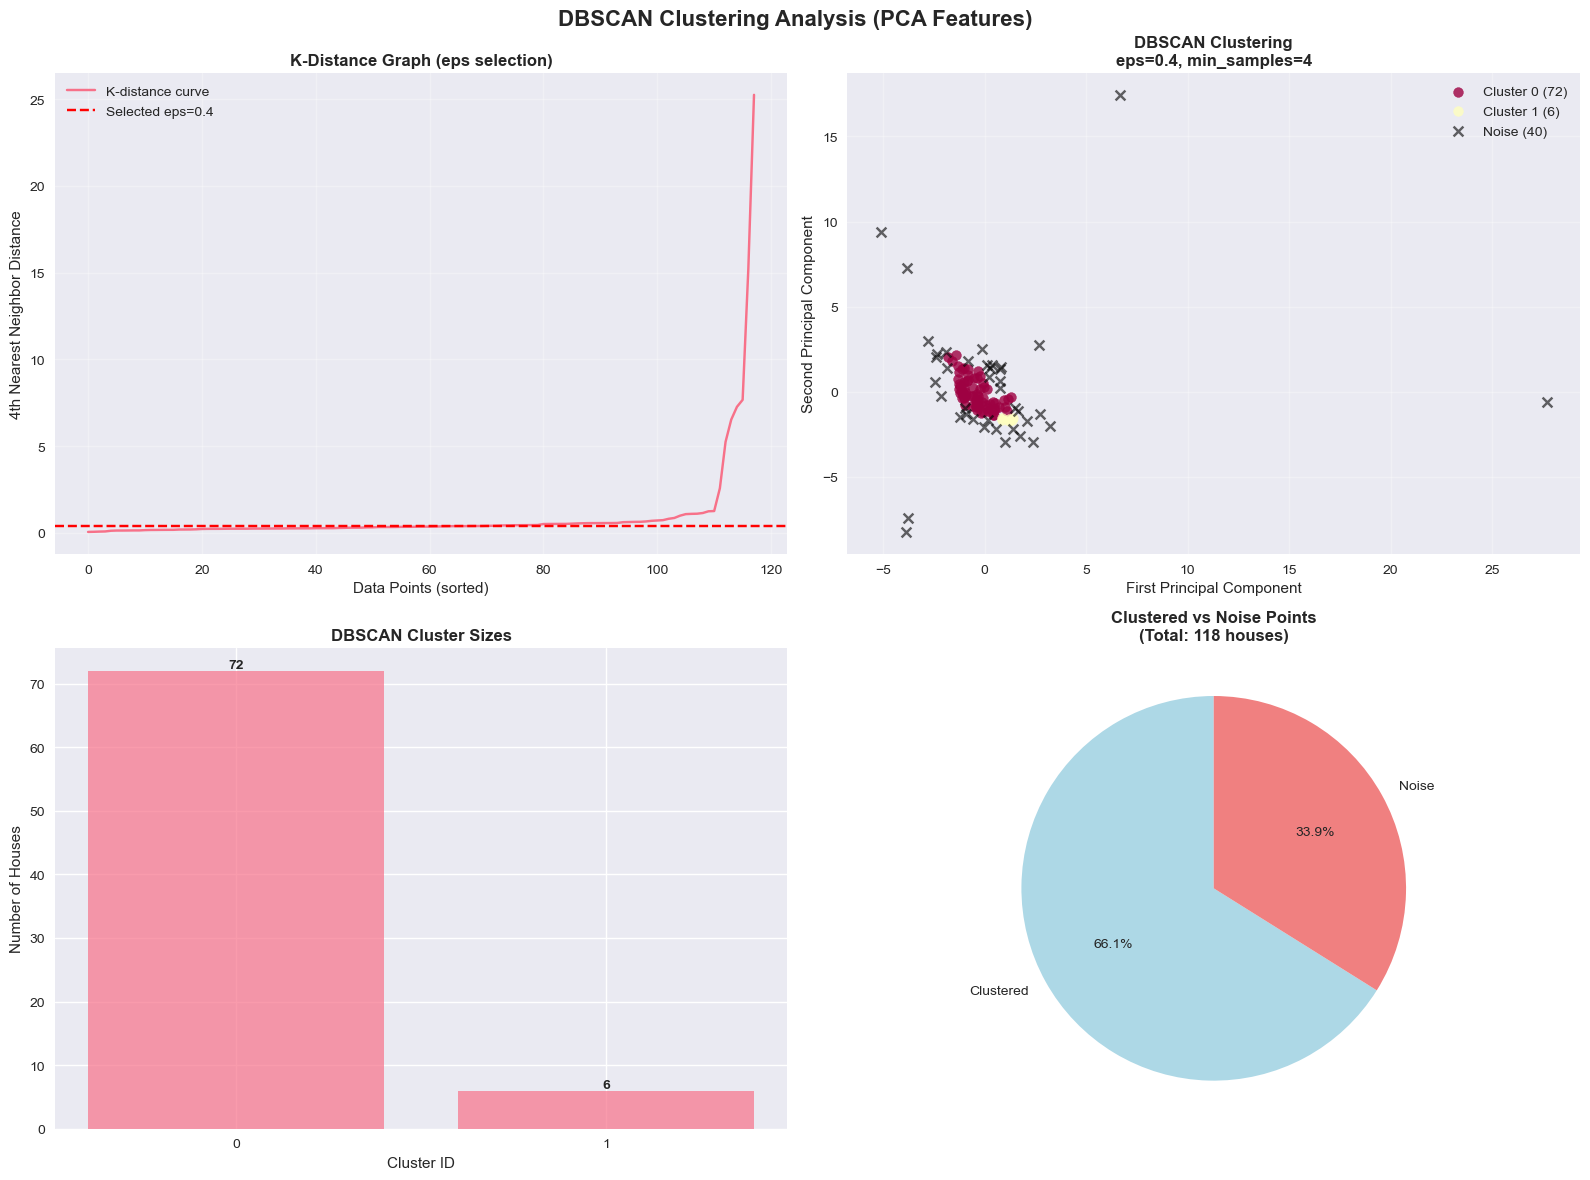

In [19]:
# Create visualisation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DBSCAN Clustering Analysis (PCA Features)', fontsize=16, fontweight='bold')

# K-distance graph for eps selection
ax_kdist = axes[0, 0]
ax_kdist.plot(distances_sorted, label='K-distance curve')
ax_kdist.axhline(y=best_params[0], color='red', linestyle='--', 
                label=f'Selected eps={best_params[0]}')
ax_kdist.set_title('K-Distance Graph (eps selection)', fontweight='bold')
ax_kdist.set_xlabel('Data Points (sorted)')
ax_kdist.set_ylabel('4th Nearest Neighbor Distance')
ax_kdist.legend()
ax_kdist.grid(True, alpha=0.3)

# DBSCAN scatter plot
ax_scatter = axes[0, 1]
unique_labels = set(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points in black
        class_member_mask = (dbscan_labels == k)
        xy = features_pca[class_member_mask]
        ax_scatter.scatter(xy[:, 0], xy[:, 1], c='black', marker='x', s=50, 
                          label=f'Noise ({np.sum(class_member_mask)})', alpha=0.6)
    else:
        class_member_mask = (dbscan_labels == k)
        xy = features_pca[class_member_mask]
        ax_scatter.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, 
                          label=f'Cluster {k} ({np.sum(class_member_mask)})', alpha=0.8)

ax_scatter.set_title(f'DBSCAN Clustering\neps={best_params[0]}, min_samples={best_params[1]}', 
                    fontweight='bold')
ax_scatter.set_xlabel('First Principal Component')
ax_scatter.set_ylabel('Second Principal Component')
ax_scatter.legend()
ax_scatter.grid(True, alpha=0.3)

# Cluster sizes (excluding noise)
ax_bar = axes[1, 0]
cluster_labels = [label for label in dbscan_labels if label != -1]
if cluster_labels:
    cluster_counts = np.bincount(cluster_labels)
    bars = ax_bar.bar(range(len(cluster_counts)), cluster_counts, alpha=0.7)
    ax_bar.set_title('DBSCAN Cluster Sizes', fontweight='bold')
    ax_bar.set_xlabel('Cluster ID')
    ax_bar.set_ylabel('Number of Houses')
    ax_bar.set_xticks(range(len(cluster_counts)))
    
    # Add count annotations
    for bar, count in zip(bars, cluster_counts):
        ax_bar.annotate(f'{count}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                       ha='center', va='bottom', fontweight='bold')

# Noise points analysis
ax_noise = axes[1, 1]
noise_mask = dbscan_labels == -1
n_noise = np.sum(noise_mask)
n_clustered = len(dbscan_labels) - n_noise

sizes = [n_clustered, n_noise]
labels = ['Clustered', 'Noise']
colors_pie = ['lightblue', 'lightcoral']

ax_noise.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax_noise.set_title(f'Clustered vs Noise Points\n(Total: {len(dbscan_labels)} houses)', fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
# Analyze DBSCAN clustering characteristics
print("DBSCAN CLUSTERING CHARACTERISTICS")

# Add DBSCAN cluster labels to dataframe
df_dbscan = features_reduced.copy()
df_dbscan['dbscan_cluster'] = dbscan_labels

print(f"\nDBSCAN Results (eps={best_params[0]}, min_samples={best_params[1]}):")
print(f"Number of clusters: {final_result['n_clusters']}")
print(f"Number of noise points: {final_result['n_noise']}")
print(f"Noise percentage: {final_result['noise_pct']:.1f}%")
print(f"Silhouette score: {final_result['silhouette']:.3f}")

DBSCAN CLUSTERING CHARACTERISTICS

DBSCAN Results (eps=0.4, min_samples=4):
Number of clusters: 2
Number of noise points: 40
Noise percentage: 33.9%
Silhouette score: 0.338


In [21]:
# Analyse each cluster
cluster_ids = [label for label in set(dbscan_labels) if label != -1]
if cluster_ids:
    print(f"\nCluster Characteristics:")
    print("Cluster\tSize\tAvg Power\tPeak Power\tAvg Rooms\tRoom Range")
   
    
    for cluster_id in sorted(cluster_ids):
        cluster_data = df_dbscan[df_dbscan['dbscan_cluster'] == cluster_id]
        size = len(cluster_data)
        avg_power = cluster_data['avg_power_kW'].mean()
        peak_power = cluster_data['peak_kW'].mean()
        avg_rooms = cluster_data['num_rooms'].mean()
        min_rooms = cluster_data['num_rooms'].min()
        max_rooms = cluster_data['num_rooms'].max()
        
        print(f"{cluster_id}\t{size}\t{avg_power:.2f} kW\t{peak_power:.2f} kW\t{avg_rooms:.1f}\t\t{min_rooms}-{max_rooms}")


Cluster Characteristics:
Cluster	Size	Avg Power	Peak Power	Avg Rooms	Room Range
0	72	1.85 kW	10.69 kW	4.7		2-6
1	6	2.72 kW	12.29 kW	5.3		4-6


In [22]:
# Analyse noise points
if final_result['n_noise'] > 0:
    print(f"\nNoise Points Analysis:")
    noise_data = df_dbscan[df_dbscan['dbscan_cluster'] == -1]
    print("Noise\tSize\tAvg Power\tPeak Power\tAvg Rooms\tRoom Range")

    avg_power = noise_data['avg_power_kW'].mean()
    peak_power = noise_data['peak_kW'].mean()
    avg_rooms = noise_data['num_rooms'].mean()
    min_rooms = noise_data['num_rooms'].min()
    max_rooms = noise_data['num_rooms'].max()
    print(f"-1\t{final_result['n_noise']}\t{avg_power:.2f} kW\t{peak_power:.2f} kW\t{avg_rooms:.1f}\t\t{min_rooms}-{max_rooms}")


Noise Points Analysis:
Noise	Size	Avg Power	Peak Power	Avg Rooms	Room Range
-1	40	2.34 kW	12.78 kW	4.4		1-11


In [23]:
print("Setting up comprehensive method comparison...")

# Create combined dataframe with all cluster assignments
df_comparison = features_reduced.copy()
df_comparison['ICP_IDENTIFIER'] = df['ICP_IDENTIFIER']

# Add cluster assignments from all methods (using K=3 for fair comparison)
kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels_k3 = kmeans_k3.fit_predict(features_scaled)

hier_k3 = AgglomerativeClustering(n_clusters=3, linkage='average')
hier_labels_k3 = hier_k3.fit_predict(features_scaled)

# Add all labels to comparison dataframe
df_comparison['kmeans_cluster'] = kmeans_labels_k3
df_comparison['hier_cluster'] = hier_labels_k3
df_comparison['dbscan_cluster'] = dbscan_labels

Setting up comprehensive method comparison...


In [24]:
print(f"\nMethod Performance Summary:")

# Calculate performance metrics
methods_performance = {
    'K-means (K=3)': {
        'silhouette': silhouette_score(features_scaled, kmeans_labels_k3),
        'clusters': len(set(kmeans_labels_k3)),
        'noise_points': 0,  # K-means doesn't have noise
        'noise_pct': 0.0
    },
    'Hierarchical (K=3)': {
        'silhouette': silhouette_score(features_scaled, hier_labels_k3),
        'clusters': len(set(hier_labels_k3)),
        'noise_points': 0,  # Hierarchical doesn't have noise
        'noise_pct': 0.0
    },
    'DBSCAN': {
        'silhouette': final_result['silhouette'] if final_result['silhouette'] > 0 else 
                     silhouette_score(features_pca[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]) if len(set(dbscan_labels[dbscan_labels != -1])) > 1 else 0,
        'clusters': final_result['n_clusters'],
        'noise_points': final_result['n_noise'],
        'noise_pct': final_result['noise_pct']
    }
}

print("Method                 Silhouette  Clusters  Noise Points  Noise %")

for method, metrics in methods_performance.items():
    method_name = method.ljust(20)
    silhouette = f"{metrics['silhouette']:.3f}".rjust(10)
    clusters = str(metrics['clusters']).rjust(8)
    noise_points = str(metrics['noise_points']).rjust(12)
    noise_pct = f"{metrics['noise_pct']:.1f}%".rjust(8)
    print(f"{method_name} {silhouette} {clusters} {noise_points} {noise_pct}")


Method Performance Summary:
Method                 Silhouette  Clusters  Noise Points  Noise %
K-means (K=3)             0.718        3            0     0.0%
Hierarchical (K=3)        0.787        3            0     0.0%
DBSCAN                    0.338        2           40    33.9%


In [25]:
# Cluster size comparison
print("Cluster Size Distribution:")

print("\nK-means (K=3) cluster sizes:")
kmeans_sizes = np.bincount(kmeans_labels_k3)
for i, size in enumerate(kmeans_sizes):
    print(f"  Cluster {i}: {size} houses")

print("\nHierarchical (K=3) cluster sizes:")
hier_sizes = np.bincount(hier_labels_k3)
for i, size in enumerate(hier_sizes):
    print(f"  Cluster {i}: {size} houses")

print("\nDBSCAN cluster sizes:")
dbscan_unique, dbscan_counts = np.unique(dbscan_labels, return_counts=True)
for label, count in zip(dbscan_unique, dbscan_counts):
    if label == -1:
        print(f"  Noise: {count} houses")
    else:
        print(f"  Cluster {label}: {count} houses")


Cluster Size Distribution:

K-means (K=3) cluster sizes:
  Cluster 0: 3 houses
  Cluster 1: 1 houses
  Cluster 2: 114 houses

Hierarchical (K=3) cluster sizes:
  Cluster 0: 116 houses
  Cluster 1: 1 houses
  Cluster 2: 1 houses

DBSCAN cluster sizes:
  Noise: 40 houses
  Cluster 0: 72 houses
  Cluster 1: 6 houses


In [26]:
# Check original dataframe columns
print("Available columns:", df.columns.tolist())

Available columns: ['ICP_IDENTIFIER', 'num_rooms', 'avg_power_kW', 'peak_kW', 'peak_to_avg_ratio', 'load_factor', 'coefficient_of_variation', 'temperature_correlation', 'heating_sensitivity_kWh', 'night_usage_ratio', 'morning_usage_ratio', 'daytime_usage_ratio', 'evening_usage_ratio', 'daily_usage_consistency', 'weekday_weekend_ratio', 'usage_concentration', 'avg_power_per_room']


In [27]:
# Agreement Analysis
print("Method Agreement Analysis:")

# Find houses that are consistently outliers
print("\nIdentifying consistent outliers...")

# For K-means and Hierarchical, find smallest clusters (likely outliers)
kmeans_outlier_mask = np.isin(kmeans_labels_k3, np.where(kmeans_sizes < 5)[0])
hier_outlier_mask = np.isin(hier_labels_k3, np.where(hier_sizes < 5)[0])
dbscan_outlier_mask = dbscan_labels == -1

# Find houses identified as outliers by multiple methods
outlier_agreement = kmeans_outlier_mask.astype(int) + hier_outlier_mask.astype(int) + dbscan_outlier_mask.astype(int)

print(f"Houses identified as outliers by:")
print(f"  - 3 methods: {np.sum(outlier_agreement == 3)} houses")
print(f"  - 2 methods: {np.sum(outlier_agreement == 2)} houses") 
print(f"  - 1 method: {np.sum(outlier_agreement == 1)} houses")
print(f"  - No methods: {np.sum(outlier_agreement == 0)} houses")

# Identify the most extreme outliers (agreed by all methods)
if np.sum(outlier_agreement == 3) > 0:
    extreme_outliers = df_comparison[outlier_agreement == 3]
    print(f"Extreme outliers (identified by all 3 methods):")
    print(f"{'House Index':<12} {'Avg Power':<12} {'Peak Power':<12} {'Rooms':<6}")
    print("-" * 50)
    for idx in extreme_outliers.index:
        house_data = extreme_outliers.loc[idx]
        icp = house_data['ICP_IDENTIFIER']
        avg_power = f"{house_data['avg_power_kW']:.2f} kW"
        peak_power = f"{house_data['peak_kW']:.2f} kW"
        rooms = f"{house_data['num_rooms']:.0f}"
        print(f"{icp:<15} {avg_power:<12} {peak_power:<12} {rooms:<6}")

# Save the 2 extreme outliers
if np.sum(outlier_agreement == 3) > 0:
    extreme_outliers = df_comparison[outlier_agreement == 3]
    extreme_outlier_icps = extreme_outliers['ICP_IDENTIFIER'].tolist()
    
    # Get full data for these outliers from original dataframe
    outlier_data = df[df['ICP_IDENTIFIER'].isin(extreme_outlier_icps)]
    
    # Save to CSV
    outlier_data.to_csv('extreme_outliers.csv', index=False)
    print(f"\n Saved {len(outlier_data)} extreme outliers to 'extreme_outliers.csv'")

Method Agreement Analysis:

Identifying consistent outliers...
Houses identified as outliers by:
  - 3 methods: 2 houses
  - 2 methods: 2 houses
  - 1 method: 36 houses
  - No methods: 78 houses
Extreme outliers (identified by all 3 methods):
House Index  Avg Power    Peak Power   Rooms 
--------------------------------------------------
0000002867DED9E 18.74 kW     55.60 kW     1     
0000003664DE6F5 1.32 kW      41.48 kW     5     

 Saved 2 extreme outliers to 'extreme_outliers.csv'


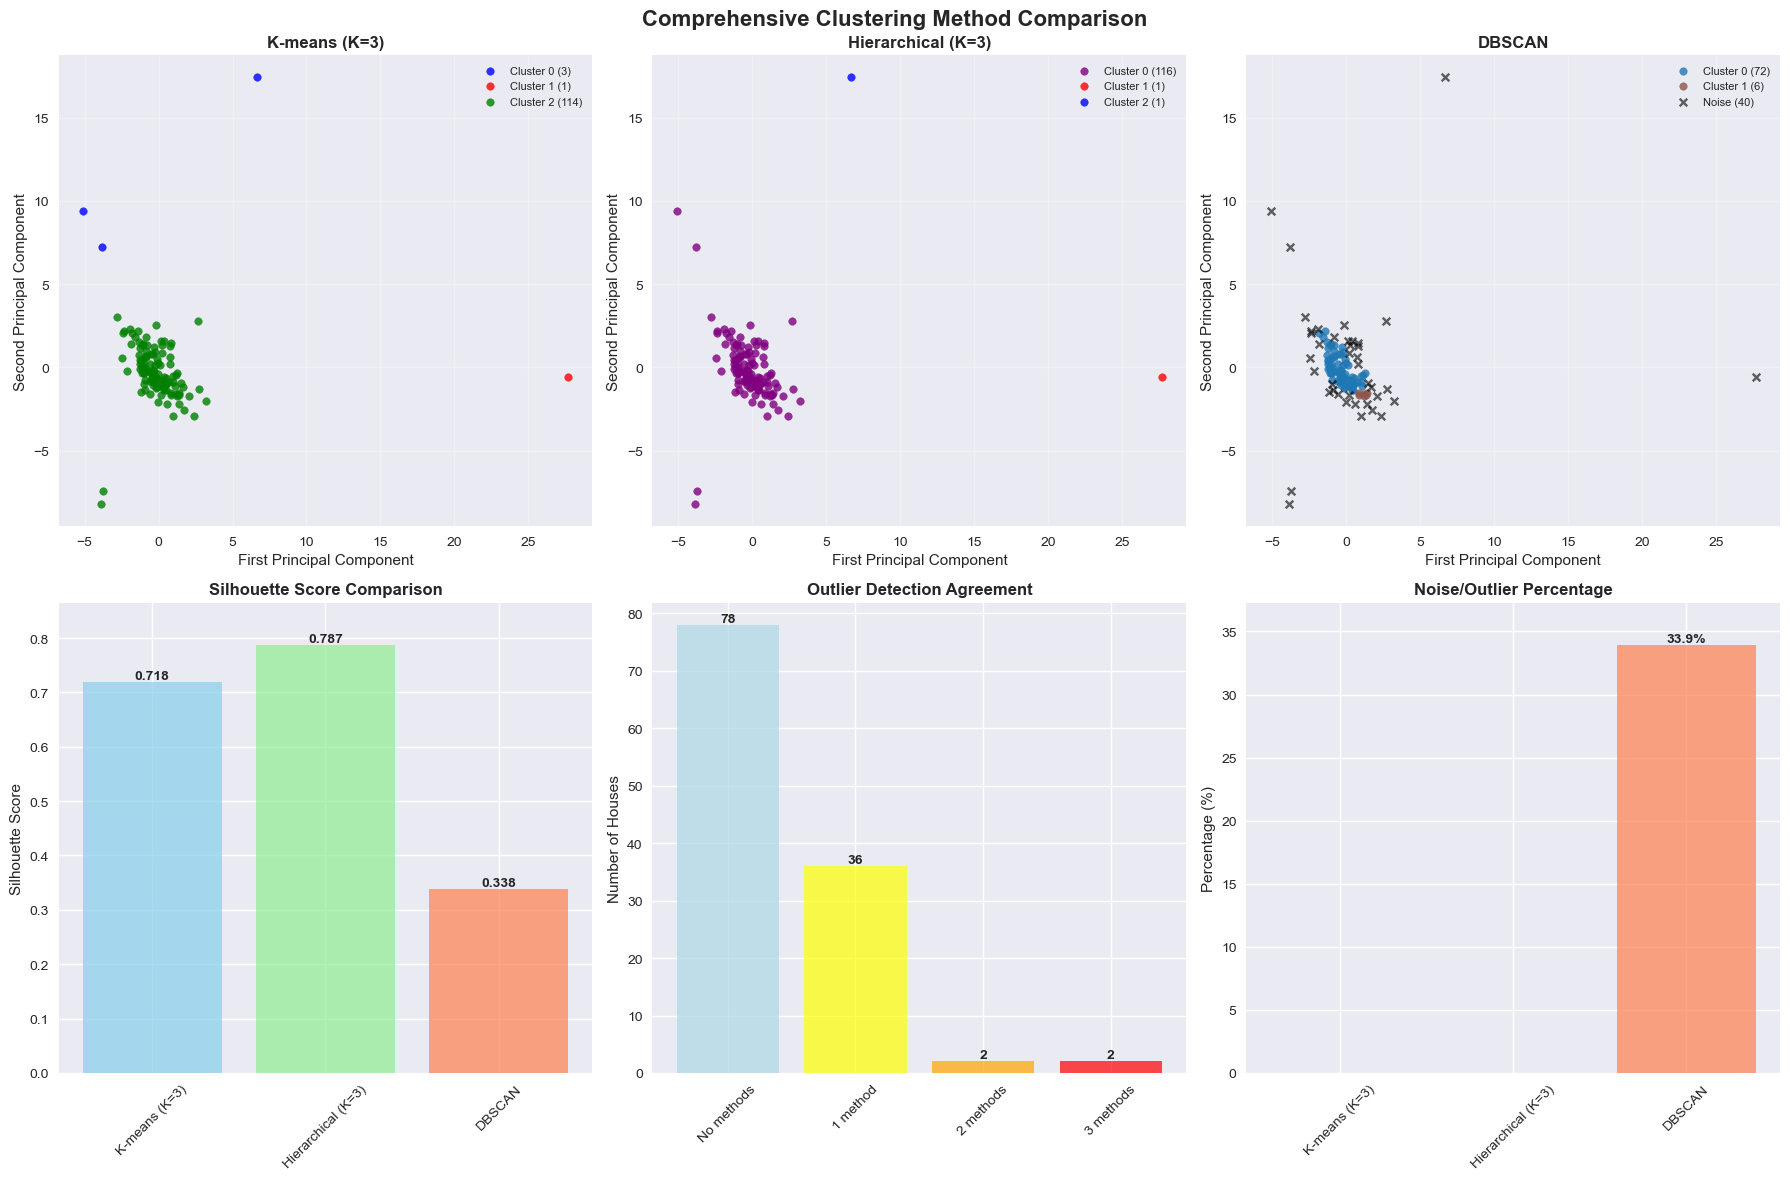

In [28]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Clustering Method Comparison', fontsize=16, fontweight='bold')

# Method comparison scatter plots
methods_data = [
    ('K-means (K=3)', kmeans_labels_k3,['blue', 'red', 'green']),
    ('Hierarchical (K=3)', hier_labels_k3, ['purple', 'red', 'blue']),
    ('DBSCAN', dbscan_labels, 'tab10')
]

for i, (method_name, labels, colormap) in enumerate(methods_data):
    ax = axes[0, i]
    
    if method_name == 'DBSCAN':
        # Keep existing DBSCAN code unchanged
        unique_labels = set(labels)
        colors = plt.colormaps.get_cmap(colormap)(np.linspace(0, 1, len(unique_labels)))
        
        for k, col in zip(unique_labels, colors):
            if k == -1:
                class_member_mask = (labels == k)
                xy = features_pca[class_member_mask]
                ax.scatter(xy[:, 0], xy[:, 1], c='black', marker='x', s=30, alpha=0.6, 
                          label=f'Noise ({np.sum(class_member_mask)})')
            else:
                class_member_mask = (labels == k)
                xy = features_pca[class_member_mask]
                ax.scatter(xy[:, 0], xy[:, 1], c=[col], s=30, alpha=0.8,
                          label=f'Cluster {k} ({np.sum(class_member_mask)})')
    else:
        # Use custom colors for K-means and Hierarchical
        unique_labels = np.unique(labels)
        
        for j, label in enumerate(unique_labels):
            mask = labels == label
            ax.scatter(features_pca[mask, 0], features_pca[mask, 1], 
                      c=colormap[j], s=30, alpha=0.8,  # Use colormap as list
                      label=f'Cluster {label} ({np.sum(mask)})')
    
    ax.set_title(method_name, fontweight='bold')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)

# Performance comparison bar chart
ax_perf = axes[1, 0]
methods = list(methods_performance.keys())
silhouettes = [methods_performance[m]['silhouette'] for m in methods]
colors_perf = ['skyblue', 'lightgreen', 'coral']

bars = ax_perf.bar(methods, silhouettes, color=colors_perf, alpha=0.7)
ax_perf.set_title('Silhouette Score Comparison', fontweight='bold')
ax_perf.set_ylabel('Silhouette Score')
ax_perf.set_ylim(0, max(silhouettes) * 1.1)
ax_perf.tick_params(axis='x', rotation=45)

for bar, score in zip(bars, silhouettes):
    ax_perf.annotate(f'{score:.3f}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontweight='bold')

# Outlier agreement visualisation
ax_outlier = axes[1, 1]
agreement_counts = [np.sum(outlier_agreement == i) for i in range(4)]
agreement_labels = ['No methods', '1 method', '2 methods', '3 methods']
colors_agreement = ['lightblue', 'yellow', 'orange', 'red']

bars_agreement = ax_outlier.bar(agreement_labels, agreement_counts, color=colors_agreement, alpha=0.7)
ax_outlier.set_title('Outlier Detection Agreement', fontweight='bold')
ax_outlier.set_ylabel('Number of Houses')
ax_outlier.tick_params(axis='x', rotation=45)

for bar, count in zip(bars_agreement, agreement_counts):
    if count > 0:
        ax_outlier.annotate(f'{count}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                           ha='center', va='bottom', fontweight='bold')

# Noise percentage comparison
ax_noise = axes[1, 2]
noise_pcts = [methods_performance[m]['noise_pct'] for m in methods]
bars_noise = ax_noise.bar(methods, noise_pcts, color=colors_perf, alpha=0.7)
ax_noise.set_title('Noise/Outlier Percentage', fontweight='bold')
ax_noise.set_ylabel('Percentage (%)')
ax_noise.set_ylim(0, max(noise_pcts) * 1.1 if max(noise_pcts) > 0 else 10)
ax_noise.tick_params(axis='x', rotation=45)

for bar, pct in zip(bars_noise, noise_pcts):
    if pct > 0:
        ax_noise.annotate(f'{pct:.1f}%', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                         ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()